## Notebook implementation: High-dimensional statistical arbitrage with factor models and stochastic control
### Paper author: Jorge Guijarro-Ordonez

This notebook is based on the above mentioned paper

In [1]:
# TODO:
# - Exponential utility with dollar neutrality does not work

In [292]:
import numpy as np
from scipy.linalg import eig, inv, cholesky
from OU_simulation import *
from Policy_Gradient_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import odeint
%reload_ext autoreload
%autoreload 2

### Part 1: Monte carlo simulations of high dimensional Ornstein-Uhlenbeck processes

In [99]:
# Same parameters are used as in the paper 
N       = 1
T       = 40
L       = 1000
delta_t = T/L
theta   = np.diag(np.random.normal(0.5, 0.1, N))
mu      = np.zeros((N,1))
sigma   = np.random.uniform(-0.3,0.3,(N,N))
sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))

In [ ]:
def initialise_parameters_OU(N,T,L):
    delta_t = T/L
    theta   = np.diag(np.random.normal(0.5, 0.1, N))
    mu      = np.zeros((N,1))
    sigma   = np.random.uniform(-0.3,0.3,(N,N))
    sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))
    return {'delta_t':delta_t,'theta':theta,'mu':mu,'sigma':sigma}


In [301]:
test = OU_process_shuffler(1,20,400)
test.step()

array([0.02073183])

In [290]:
# Initialise the process
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
X       = np.zeros((N,L))
Y       = np.zeros((N,L))

# Perform a monte carlo simulation
for idx in range(L):
    X[:,idx] = process.step()
    Y[:,idx] = process.Yt

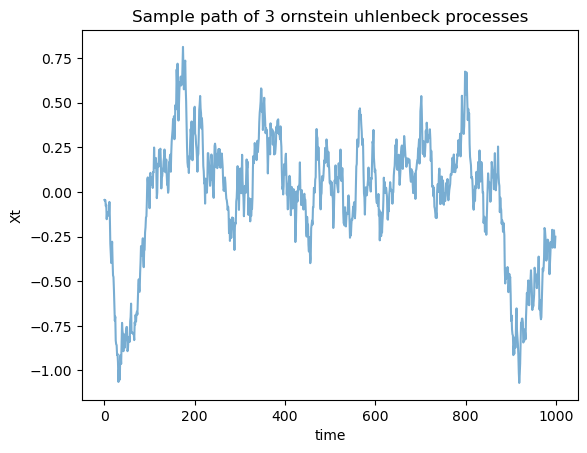

In [101]:
plt.plot(np.transpose(X[:3,:]),alpha=0.6)
plt.title('Sample path of 3 ornstein uhlenbeck processes')
plt.xlabel('time')
plt.ylabel('Xt')
plt.show()

### Part 2: stochastic control solutions applied to the monte carlo paths

#### 2.1 Exponential utility strategy & Mean variance case

In [185]:
r  = 0.02 # 2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
gammas = [1,2,3,4]
Wealth_EU = np.zeros((M,L,len(gammas)))
Wealth_MV = np.zeros((M,L,len(gammas)))


# repeat the monte carlo simulation M times
for sim in tqdm(range(M)):
    X        = np.zeros((N,L))
    pi_EU       = np.zeros((N,L,len(gammas)))
    pi_MV       = np.zeros((N,L,len(gammas)))
    W_EU        = np.zeros((L,len(gammas)))
    W_MV        = np.zeros((L,len(gammas)))
    W_EU[:,0]   = W0
    W_MV[:,0]   = W0

    # initialise the process at t=0
    process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    for idx in range(L):
        # perform a simulation for one time step
        X_t  = process.step().reshape((-1,1))
        t    = process.t
        X[:,idx] = X_t.reshape((1,-1))

        # calculate the change to the wealth
        if idx > 0:
            for count, gamma in enumerate(gammas):
                dW_t_EU = pi_EU[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_EU[idx-1,count] - pi_EU[:,idx-1,count].transpose() @ p)*r * delta_t
                W_EU[idx,count] = W_EU[idx-1,count] + dW_t_EU

                dW_t_MV = pi_MV[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_MV[idx-1,count] - pi_MV[:,idx-1,count].transpose() @ p)*r * delta_t
                W_MV[idx,count] = W_MV[idx-1,count] + dW_t_MV
        
        # Simulating the exponential-utility strategy
        sigma_perp_inv = inv(sigma @ sigma.transpose())
        for count, gamma in enumerate(gammas):
            pi_t_EU = sigma_perp_inv @ (theta @ (mu - X_t) - p*r) / (gamma*np.exp(r*(T-t))) + theta.transpose() @ (sigma_perp_inv) /(gamma*np.exp(r*(T-t))) @ (theta @ (mu-X_t) - p*r) * (T-t) - theta @ p *r*(T-t)**2/2
            pi_t_MV = inv(gamma*np.exp(2*r*(T-t))*sigma @ sigma.transpose()) @ (theta @ (mu - X_t) - p * r)*np.exp(r*(T-t))

            pi_EU[:,idx, count] = pi_t_EU.reshape((1,-1))
            pi_MV[:,idx, count] = pi_t_MV.reshape((1,-1))


    Wealth_EU[sim,:,:] = W_EU
    Wealth_MV[sim,:,:] = W_MV

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


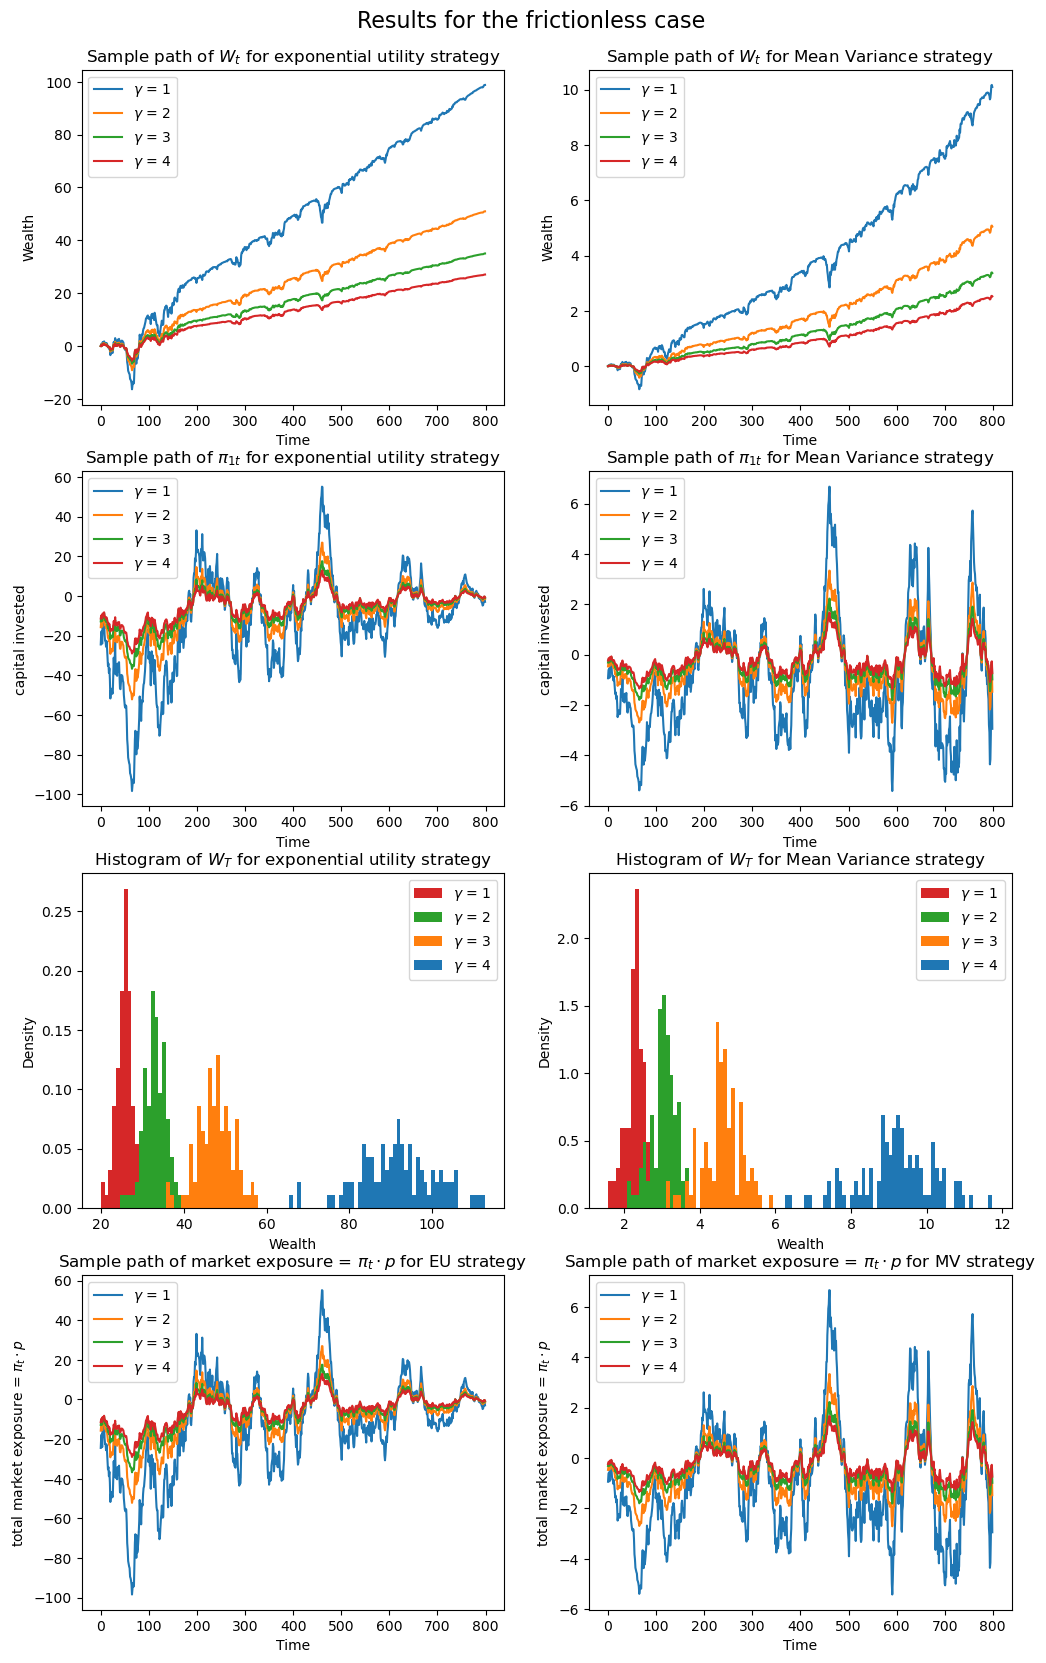

In [186]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
fig.suptitle('Results for the frictionless case', fontsize=16, y = 0.91)
# plot a sample path of the wealth
ax[0,0].plot(Wealth_EU[-1,:,:])
ax[0,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[0,0].set_title(r'Sample path of $W_t$ for exponential utility strategy')
ax[0,0].set_ylabel('Wealth')
ax[0,0].set_xlabel('Time')

ax[0,1].plot(Wealth_MV[-1,:,:])
ax[0,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[0,1].set_title(r'Sample path of $W_t$ for Mean Variance strategy')
ax[0,1].set_ylabel('Wealth')
ax[0,1].set_xlabel('Time')

# plot a sample path of the capital invested in the first asset 
ax[1,0].plot(pi_EU[0,:,:])
ax[1,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[1,0].set_title(r'Sample path of $\pi_{1t}$ for exponential utility strategy')
ax[1,0].set_ylabel('capital invested')
ax[1,0].set_xlabel('Time')

ax[1,1].plot(pi_MV[0,:,:])
ax[1,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[1,1].set_title(r'Sample path of $\pi_{1t}$ for Mean Variance strategy')
ax[1,1].set_ylabel('capital invested')
ax[1,1].set_xlabel('Time')


# plot the density
ax[2,0].hist(Wealth_EU[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[2,0].set_title(r'Histogram of $W_T$ for exponential utility strategy')
ax[2,0].set_xlabel('Wealth')
ax[2,0].set_ylabel('Density')

ax[2,1].hist(Wealth_MV[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[2,1].set_title(r'Histogram of $W_T$ for Mean Variance strategy')
ax[2,1].set_xlabel('Wealth')
ax[2,1].set_ylabel('Density')

# plot the total market allocation
ax[3,0].plot(pi_EU.sum(axis=0))
ax[3,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[3,0].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for EU strategy')
ax[3,0].set_xlabel('Time')
ax[3,0].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

ax[3,1].plot(pi_MV.sum(axis=0))
ax[3,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[3,1].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for MV strategy')
ax[3,1].set_xlabel('Time')
ax[3,1].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

plt.show()

#### 2.2 Imposing dollar neutrality

In [187]:
import scipy.integrate

In [314]:
#old version
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
gammas = [1,2,3,4]
alpha  = 50 # market neutrality penalty
Wealth_EU = np.zeros((M,L,len(gammas)))
Wealth_MV = np.zeros((M,L,len(gammas)))

# I need to solve a ricatti matrix ODE, and a linear system of ODE's for use later on
C = np.zeros((N,N,L,len(gammas)))
b = np.zeros((N,L,len(gammas)))
for count, gamma in enumerate(gammas):
    print(count)
    # first Ricatti ODE
    def odefunc1(u,c, sigma, theta, r, gamma, alpha, p ): # u = T-t
        c     = c.reshape((N,N))
        sigma_sigma_transpose = sigma @ sigma.transpose()
        dc_du = theta.transpose() @ c + c @ theta + gamma * c @ sigma_sigma_transpose @ c - np.exp(r*u) \
            * (theta + gamma * sigma_sigma_transpose @ c).transpose() @ inv(gamma* sigma_sigma_transpose * np.exp(r*u) + alpha * p @ p.transpose()) \
            @ (theta + gamma * sigma_sigma_transpose @ c) 
        return dc_du.reshape(-1)
    
    func1 = lambda c,u: odefunc1(c,u, sigma, theta, r, gamma, alpha,p)

    sol = scipy.integrate.solve_ivp(method='RK23', fun=func1,y0=np.zeros(N*N),t_eval=np.linspace(0,T,L),t_span=(0,T),dense_output=True)
    C[:,:,:,count] = sol.y.reshape((N,N,L)) # Remember the values need to be accessed in reverse order on the time axis!!
    
    # second linear system of ODE's
    def odefunc2(u,b, theta, mu,r, gamma, sigma, p, c_sol):
        b = b.reshape((N,1))
        c = c_sol.sol(u).reshape((N,N))
        db_du = theta.transpose() @ b - c @ theta @ mu - np.exp(r*u) * \
            (theta + gamma * sigma @ sigma.transpose() @ c) @ \
                inv(gamma * sigma @ sigma.transpose()*np.exp(r*u) + alpha * p @ p.transpose()) @ \
                (theta @ mu - p * r - gamma * sigma @ sigma.transpose() @ b) + gamma * c @ sigma @ sigma.transpose() @ b
        return db_du.reshape(-1)
    
    func2 = lambda u,b: odefunc2(u,b,theta, mu,r, gamma, sigma, p, sol)
    sol = scipy.integrate.solve_ivp(method='Radau', fun=func2, y0=np.zeros(N),t_eval=np.linspace(0,T,L),t_span=(0,T),dense_output=True)
    b[:,:,count] = sol.y
    
# repeat the monte carlo simulation M times
for sim in tqdm(range(M)):
    X        = np.zeros((N,L))
    pi_EU       = np.zeros((N,L,len(gammas)))
    pi_MV       = np.zeros((N,L,len(gammas)))
    W_EU        = np.zeros((L,len(gammas)))
    W_MV        = np.zeros((L,len(gammas)))
    W_EU[:,0]   = W0
    W_MV[:,0]   = W0

    # initialise the process at t=0
    process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    for idx in range(L):
        # perform a simulation for one time step
        X_t  = process.step().reshape((-1,1))
        t    = process.t
        X[:,idx] = X_t.reshape((1,-1))

        # calculate the change to the wealth
        if idx > 0:
            for count, gamma in enumerate(gammas):
                dW_t_EU = pi_EU[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_EU[idx-1,count] - pi_EU[:,idx-1,count].transpose() @ p)*r * delta_t
                W_EU[idx,count] = W_EU[idx-1,count] + dW_t_EU

                dW_t_MV = pi_MV[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_MV[idx-1,count] - pi_MV[:,idx-1,count].transpose() @ p)*r * delta_t
                W_MV[idx,count] = W_MV[idx-1,count] + dW_t_MV
        
        # Simulating the exponential-utility and mean variance strategy
        sigma_perp_inv = inv(sigma @ sigma.transpose())
        for count, gamma in enumerate(gammas):
            pi_t_MV = inv(gamma * np.exp(r*(T-t)) * sigma @ sigma.transpose() + alpha * p @ p.transpose()) @ \
                (theta @ (mu - X_t) - p*r)*np.exp(r*(T-t))
            pi_t_EU = -1*inv(gamma*np.exp(r*(T-t))*sigma @ sigma.transpose() + alpha * p @ p.transpose()) @ \
                (theta @ (mu - X_t) - p * r - gamma * sigma @ sigma.transpose() @ (C[:,:,-idx-1,count] @ X_t+ b[:,-idx-1,count].reshape((-1,1)) ))

            pi_EU[:,idx, count] = pi_t_EU.reshape((1,-1))
            pi_MV[:,idx, count] = pi_t_MV.reshape((1,-1))


    Wealth_EU[sim,:,:] = W_EU
    Wealth_MV[sim,:,:] = W_MV

0


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_17995/1463468533.py:33: RuntimeWarning: overflow encountered in matmul
  db_du = theta.transpose() @ b - c @ theta @ mu - np.exp(r*u) * \


ValueError: array must not contain infs or NaNs

In [337]:
# new version
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
gammas = [1,2,3,4]
alpha  = 1 # market neutrality penalty
Wealth_EU = np.zeros((M,L,len(gammas)))
Wealth_MV = np.zeros((M,L,len(gammas)))

# I need to solve a ricatti matrix ODE, and a linear system of ODE's for use later on
C = np.zeros((N,N,L,len(gammas)))
b = np.zeros((N,L,len(gammas)))
for count, gamma in enumerate(gammas):
    print(count)
    # first Ricatti ODE
    def odefunc1(u,c, sigma, theta, r, gamma, alpha, p ): # u = T-t
        c     = c.reshape((N,N))
        sigma_sigma_transpose = sigma @ sigma.transpose()
        dc_du = -1*theta.transpose() @ c - c @ theta - gamma * c @ sigma_sigma_transpose @ c + np.exp(r*u) \
            * (theta + gamma * sigma_sigma_transpose @ c).transpose() @ inv(gamma* sigma_sigma_transpose * np.exp(r*u) + alpha * p @ p.transpose()) \
            @ (theta + gamma * sigma_sigma_transpose @ c) 
        return dc_du.reshape(-1)
    
    func1 = lambda c,u: odefunc1(c,u, sigma, theta, r, gamma, alpha,p)

    sol1 = scipy.integrate.solve_ivp(method='RK45', fun=func1,y0=np.zeros(N*N),t_eval=np.linspace(0,T,L),t_span=(0,T),dense_output=True)
    C[:,:,:,count] = sol1.y.reshape((N,N,L)) # Remember the values need to be accessed in reverse order on the time axis!!
    
    # second linear system of ODE's
    def odefunc2(u,b, theta, mu,r, gamma, sigma, p, c_sol):
        b = b.reshape((N,1))
        c = c_sol.sol(u).reshape((N,N)) 
        db_du = -1* theta.transpose() @ b + c @ theta @ mu - np.exp(r*u) * \
            (theta + gamma * sigma @ sigma.transpose() @ c) @ \
                inv(gamma * sigma @ sigma.transpose()*np.exp(r*u) + alpha * p @ p.transpose()) @ \
                (theta @ mu - p * r - gamma * sigma @ sigma.transpose() @ b) - gamma * c @ sigma @ sigma.transpose() @ b
        #                                                                 
        return db_du.reshape(-1)
    
    func2 = lambda u,b: odefunc2(u,b,theta, mu, r, gamma, sigma, p, sol1)
    sol2 = scipy.integrate.solve_ivp(method='BDF', fun=func2, y0=np.zeros(N),t_eval=np.linspace(0,T,L),t_span=(0,T),dense_output=False)
    b[:,:,count] = sol2.y
    
# repeat the monte carlo simulation M times
for sim in tqdm(range(M)):
    X        = np.zeros((N,L))
    pi_EU       = np.zeros((N,L,len(gammas)))
    pi_MV       = np.zeros((N,L,len(gammas)))
    W_EU        = np.zeros((L,len(gammas)))
    W_MV        = np.zeros((L,len(gammas)))
    W_EU[:,0]   = W0
    W_MV[:,0]   = W0

    # initialise the process at t=0
    process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    for idx in range(L):
        # perform a simulation for one time step
        X_t  = process.step().reshape((-1,1))
        t    = process.t
        X[:,idx] = X_t.reshape((1,-1))

        # calculate the change to the wealth
        if idx > 0:
            for count, gamma in enumerate(gammas):
                dW_t_EU = pi_EU[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_EU[idx-1,count] - pi_EU[:,idx-1,count].transpose() @ p)*r * delta_t
                W_EU[idx,count] = W_EU[idx-1,count] + dW_t_EU

                dW_t_MV = pi_MV[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_MV[idx-1,count] - pi_MV[:,idx-1,count].transpose() @ p)*r * delta_t
                W_MV[idx,count] = W_MV[idx-1,count] + dW_t_MV
        
        # Simulating the exponential-utility and mean variance strategy
        sigma_perp_inv = inv(sigma @ sigma.transpose())
        for count, gamma in enumerate(gammas):
            pi_t_MV = inv(gamma * np.exp(r*(T-t)) * sigma @ sigma.transpose() + alpha * p @ p.transpose()) @ \
                (theta @ (mu - X_t) - p*r)*np.exp(r*(T-t))
            pi_t_EU = inv(gamma*np.exp(r*(T-t))*sigma @ sigma.transpose() + alpha * p @ p.transpose()) @ \
                (theta @ (mu - X_t) - p * r - gamma * sigma @ sigma.transpose() @ (C[:,:,-idx-1,count] @ X_t+ b[:,-idx-1,count].reshape((-1,1)) ))

            pi_EU[:,idx, count] = pi_t_EU.reshape((1,-1))
            pi_MV[:,idx, count] = pi_t_MV.reshape((1,-1))


    Wealth_EU[sim,:,:] = W_EU
    Wealth_MV[sim,:,:] = W_MV

0


/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_17995/3328657340.py:34: RuntimeWarning: overflow encountered in matmul
  db_du = -1* theta.transpose() @ b + c @ theta @ mu - np.exp(r*u) * \


ValueError: array must not contain infs or NaNs

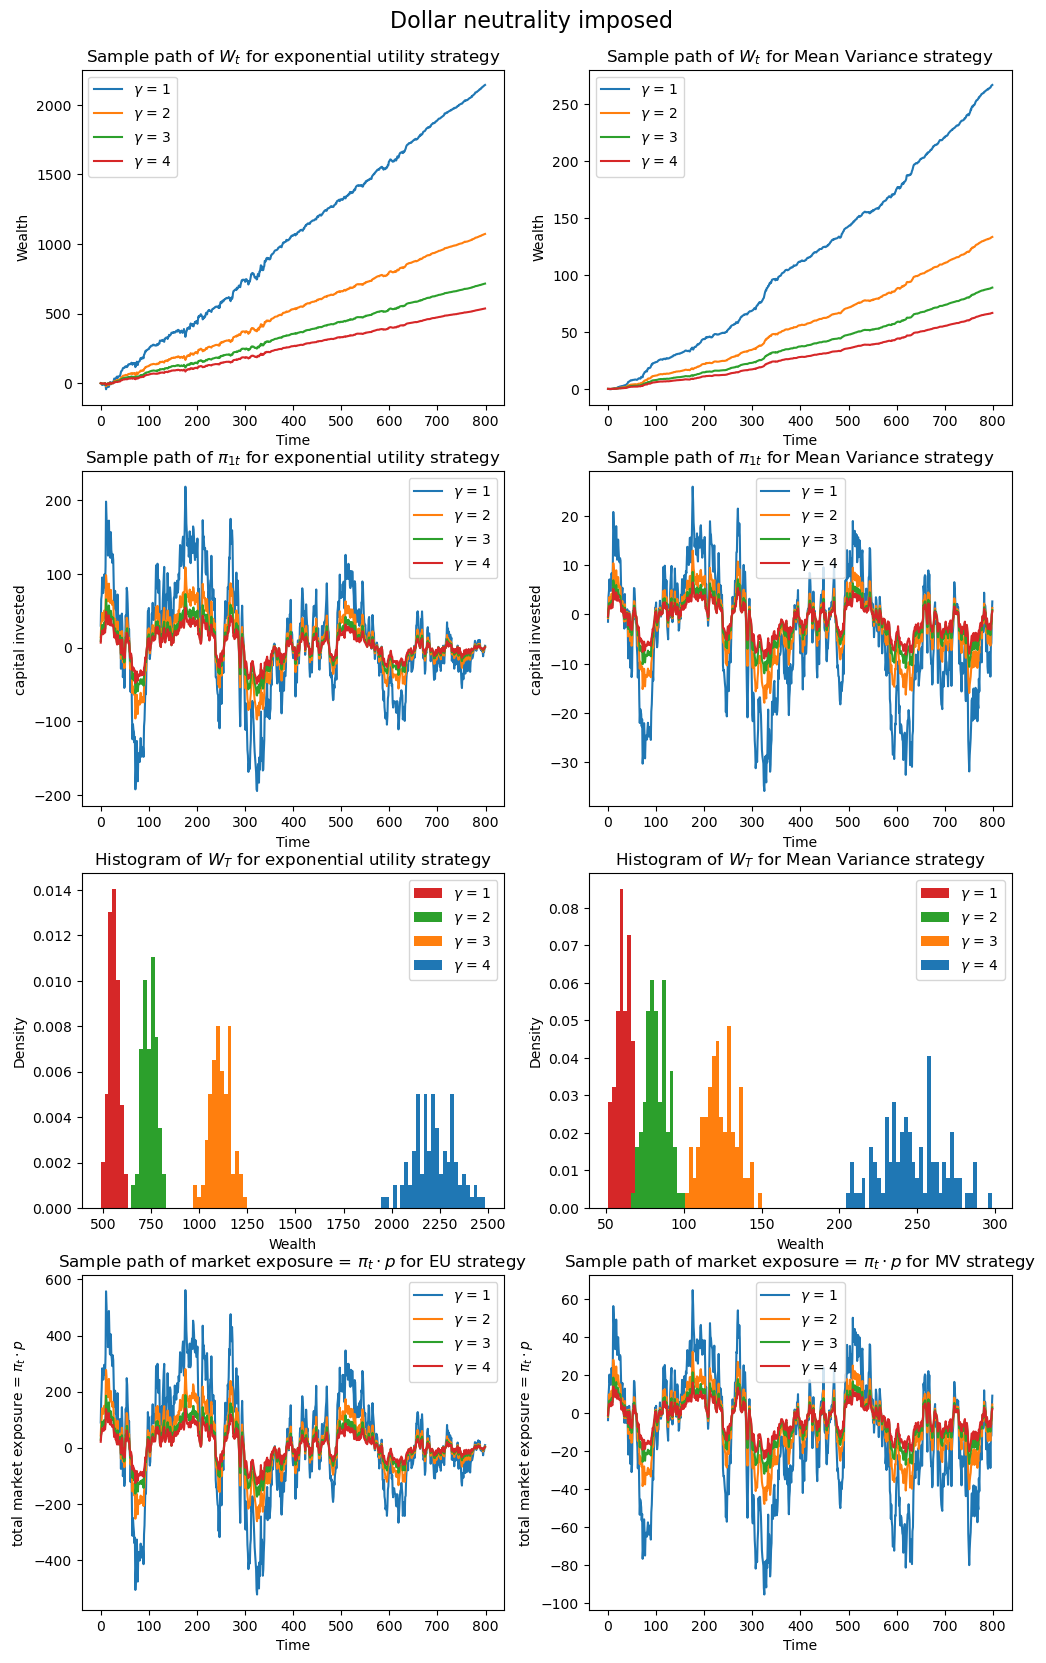

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
fig.suptitle('Dollar neutrality imposed', fontsize=16, y = 0.91)
# plot a sample path of the wealth
ax[0,0].plot(Wealth_EU[-1,:,:])
ax[0,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[0,0].set_title(r'Sample path of $W_t$ for exponential utility strategy')
ax[0,0].set_ylabel('Wealth')
ax[0,0].set_xlabel('Time')

ax[0,1].plot(Wealth_MV[-1,:,:])
ax[0,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[0,1].set_title(r'Sample path of $W_t$ for Mean Variance strategy')
ax[0,1].set_ylabel('Wealth')
ax[0,1].set_xlabel('Time')

# plot a sample path of the capital invested in the first asset 
ax[1,0].plot(pi_EU[0,:,:])
ax[1,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[1,0].set_title(r'Sample path of $\pi_{1t}$ for exponential utility strategy')
ax[1,0].set_ylabel('capital invested')
ax[1,0].set_xlabel('Time')

ax[1,1].plot(pi_MV[0,:,:])
ax[1,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[1,1].set_title(r'Sample path of $\pi_{1t}$ for Mean Variance strategy')
ax[1,1].set_ylabel('capital invested')
ax[1,1].set_xlabel('Time')


# plot the density
ax[2,0].hist(Wealth_EU[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[2,0].set_title(r'Histogram of $W_T$ for exponential utility strategy')
ax[2,0].set_xlabel('Wealth')
ax[2,0].set_ylabel('Density')

ax[2,1].hist(Wealth_MV[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[2,1].set_title(r'Histogram of $W_T$ for Mean Variance strategy')
ax[2,1].set_xlabel('Wealth')
ax[2,1].set_ylabel('Density')

# plot the total market allocation
ax[3,0].plot(pi_EU.sum(axis=0))
ax[3,0].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[3,0].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for EU strategy')
ax[3,0].set_xlabel('Time')
ax[3,0].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

ax[3,1].plot(pi_MV.sum(axis=0))
ax[3,1].legend([r'$\gamma$ = 1',r'$\gamma$ = 2',r'$\gamma$ = 3',r'$\gamma$ = 4'])
ax[3,1].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for MV strategy')
ax[3,1].set_xlabel('Time')
ax[3,1].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

plt.show()

#### 2.3 Quadratic transaction costs

### Part 3: Deep reinforcement learning applied to the monte carlo paths

In [187]:
# Same parameters are used as in the paper 
N       = 1
T       = 40
L       = 1000
delta_t = T/L
theta   = np.diag(np.random.normal(0.5, 0.1, N))
mu      = np.zeros((N,1))
sigma   = np.random.uniform(-0.3,0.3,(N,N))
sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))

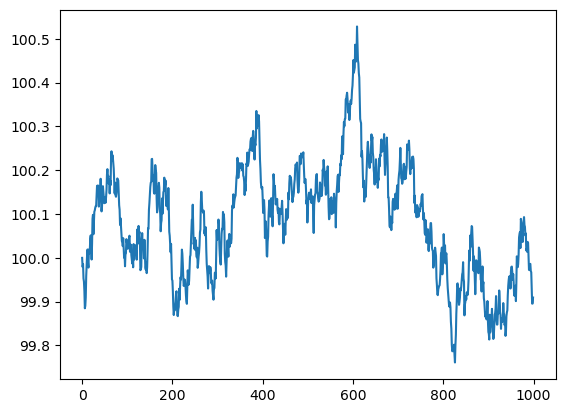

In [188]:
p = np.ones(N)
process  = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
test_env = TradingEnvironment(process,T,0,p, mode='portfolio')
test_env.reset()

done = False
while not done:
    state, reward, done, _ = test_env.step(np.ones(N))
plt.plot(test_env.W.transpose())

In [144]:
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
env     = TradingEnvironment(process,T,r,p)

def init_weights(m):
    """ Initializes the ANNs weights with a relevant distribution. """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        #m.bias.data.fill_(0)

#### 3.1 Actor-Critic reinforcement learning 

First the policy and value models need to be created 

C-RL converges for 1 asset with hidden_dim=5 and learning_rate= 0.003
but does not converge for 100 assets with hidden_dim=500 and learning rate =0.0003

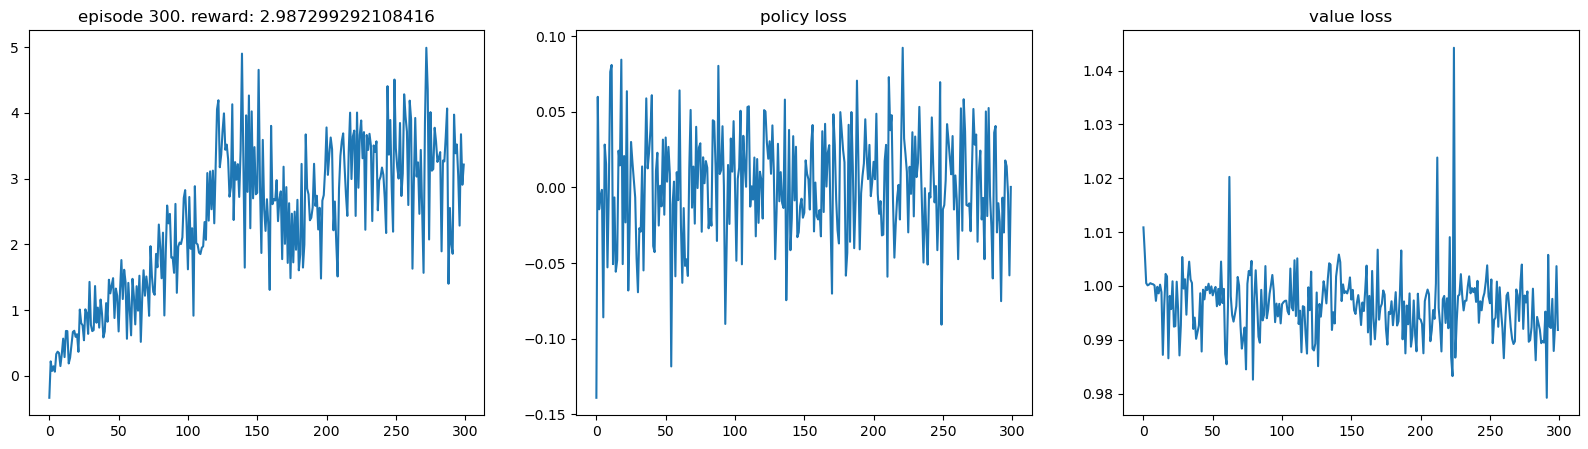

In [103]:
LEARNING_RATE = 0.03
MAX_EPISODES = 300
DISCOUNT_FACTOR = 0
N_TRIALS = 25

INPUT_DIM  = N#2 * N + 1# first N input values is X_t and the next is pi_t
HIDDEN_DIM = 5
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC)
agent = ActorCritic(actor, critic)

agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
train_env = TradingEnvironment(process,T,r,p)
train_env.eval()
eval_env = TradingEnvironment(process,T,r,p)
eval_env.eval()

for episode in range(1, MAX_EPISODES+1):
    policy_loss, value_loss, train_reward = train(train_env, agent, optimizer, DISCOUNT_FACTOR)
    test_reward = evaluate(eval_env, agent, False)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, train_rewards, policy_losses, value_losses)

#### 3.2 Proximal Policy Optimisation (PPO)

Using only $X_t$ as a state feature and $\alpha$ = 0

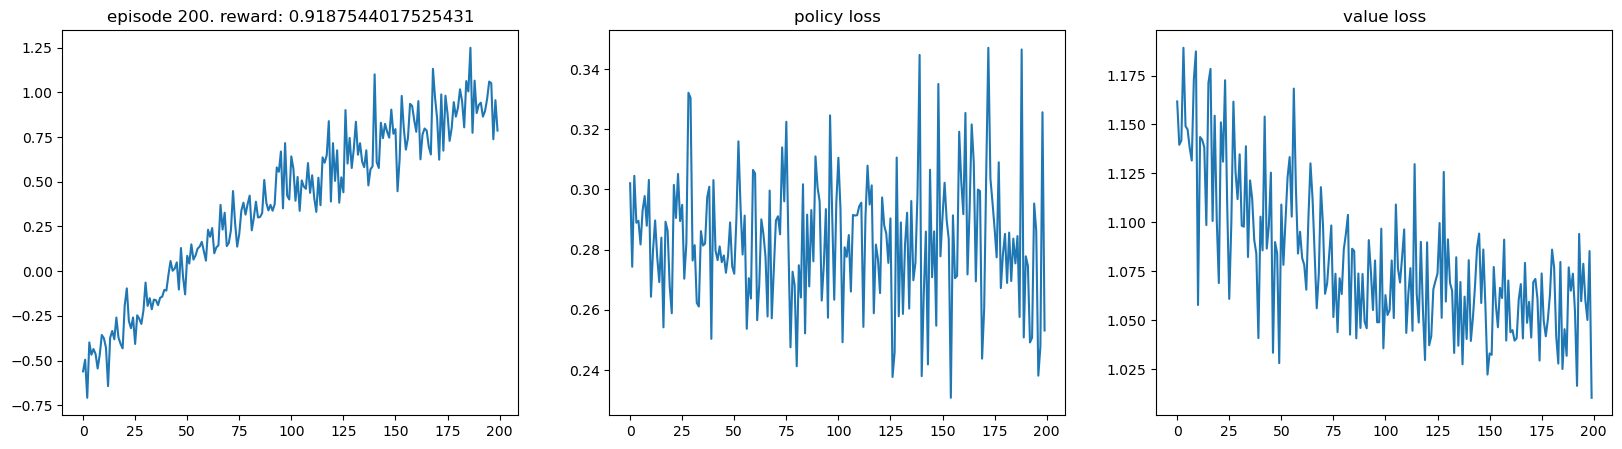

In [37]:
MAX_EPISODES = 200
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.0
N_TRIALS = 25
PPO_STEPS = 5
PPO_CLIP = 0.2

INPUT_DIM  = N # first N input values is X_t and the next is pi_t
HIDDEN_DIM = 50  #2*N+1
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
r = 0
train_env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=10, max_change=5)
eval_env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=10, max_change=5)

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR,dropout=0.3)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC, dropout=0.3)
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer,scheduler, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, test_rewards, policy_losses, value_losses)

Text(0.5, 1.0, 'sample path of $W_t$')

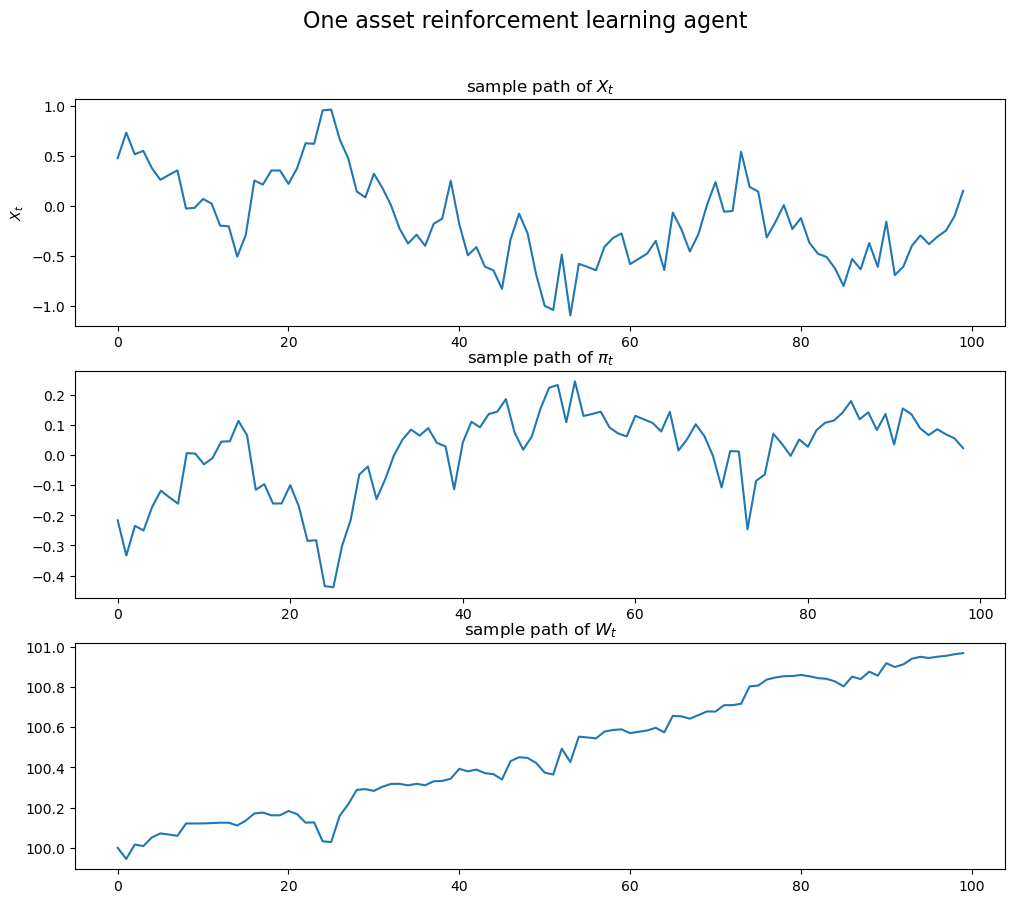

In [38]:
state,_ = train_env.reset()
done = False
val_predictions = []
while not done:
    state = torch.FloatTensor(state['values']).unsqueeze(0)
    action, _, value_pred = agent.forward(state)
    val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = train_env.step(action.detach().numpy())
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
fig.suptitle('One asset reinforcement learning agent', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(train_env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(train_env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(train_env.W)
ax[2].set_title(r'sample path of $W_t$')


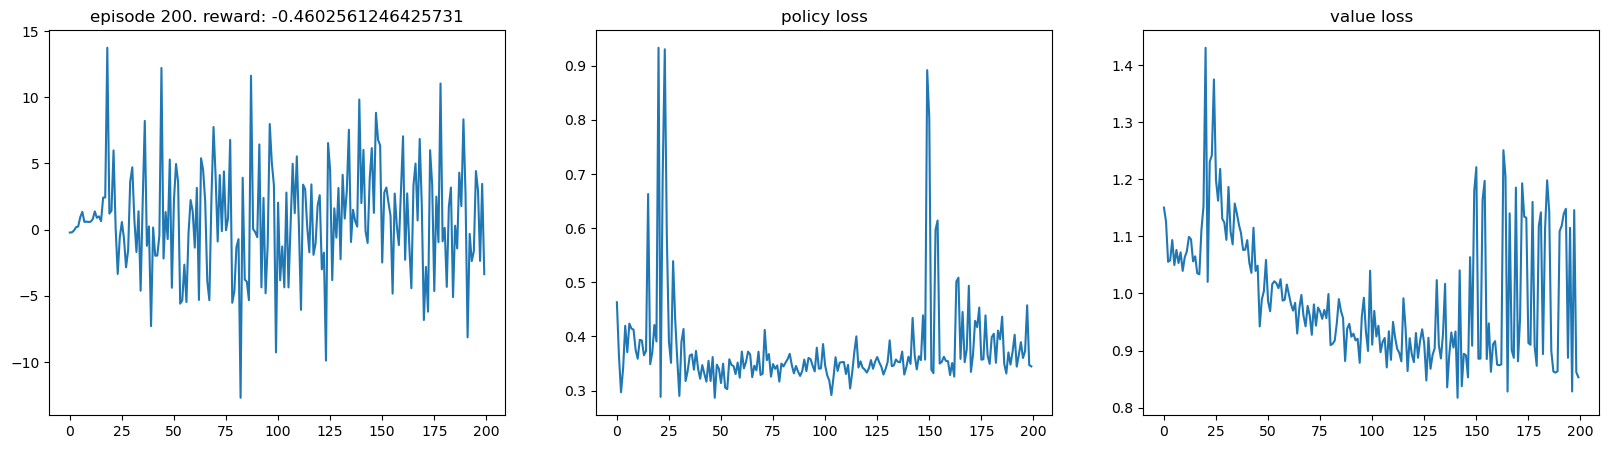

In [54]:
MAX_EPISODES = 200
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
PPO_STEPS = 10
PPO_CLIP = 0.1

INPUT_DIM  = 2*N # first N input values is X_t and the next is pi_t
HIDDEN_DIM = 100  #2*N+1
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
r = 0
train_env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=10, max_change=5)
eval_env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=10, max_change=5)

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR,dropout=0.3)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC, dropout=0.3)
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer,scheduler, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, test_rewards, policy_losses, value_losses)

Text(0.5, 1.0, 'sample path of $W_t$')

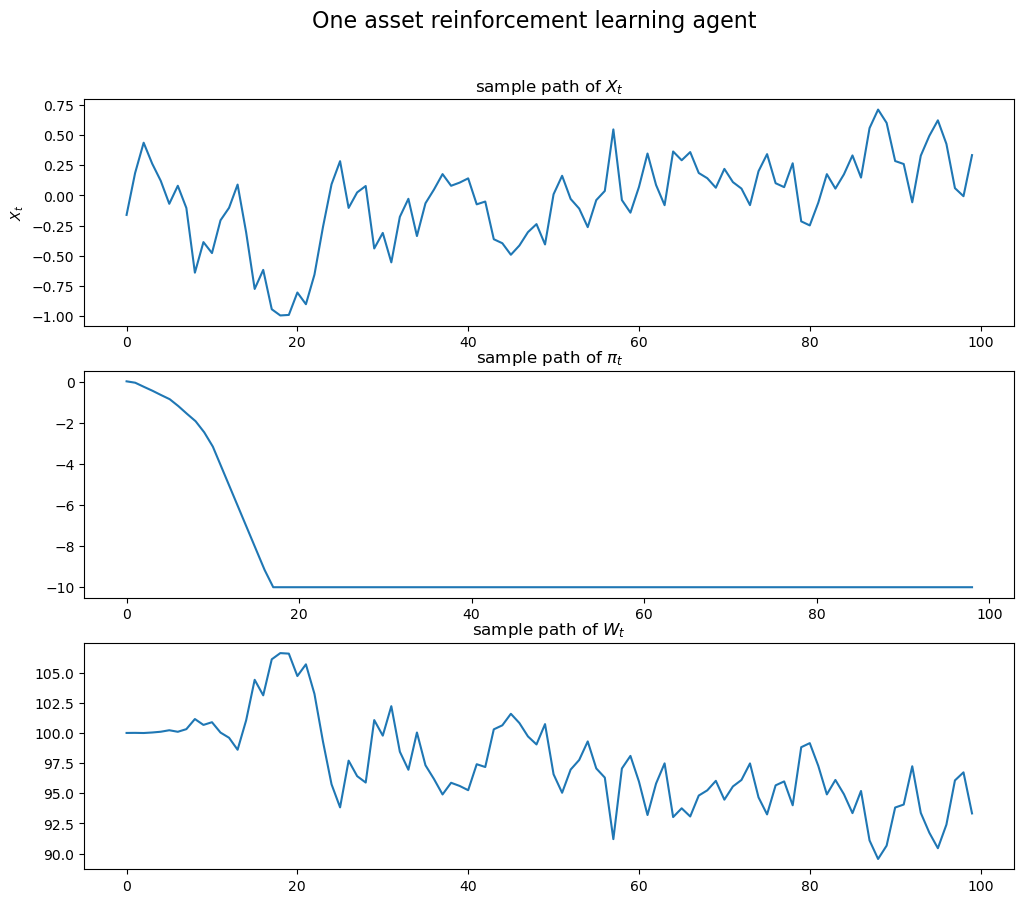

In [56]:
state, _ = train_env.reset()
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = torch.cat((torch.FloatTensor(state['values']),torch.FloatTensor(state['portfolio']))).unsqueeze(0)


    action, _, value_pred = agent.forward(state)
    val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = train_env.step(action.detach().numpy())
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
fig.suptitle('One asset reinforcement learning agent', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(train_env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(train_env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(train_env.W)
ax[2].set_title(r'sample path of $W_t$')

#### 3.2 twin delayed deep deterministic policy gradient (TD3)

In [152]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cpu'

class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action, hidden_dimension):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, hidden_dimension)
		self.l2 = nn.Linear(hidden_dimension, hidden_dimension)
		self.l3 = nn.Linear(hidden_dimension, action_dim)
		
		self.max_action = max_action
		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim,hidden_dimension):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, hidden_dimension)
        self.l2 = nn.Linear(hidden_dimension, hidden_dimension)
        self.l3 = nn.Linear(hidden_dimension, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, hidden_dimension)
        self.l5 = nn.Linear(hidden_dimension, hidden_dimension)
        self.l6 = nn.Linear(hidden_dimension, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

class TD3(object):
	def __init__(
		self,
		state_dim,
		action_dim,
		max_action,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2,
		hidden_dimension = 256
	):

		self.actor = Actor(state_dim, action_dim, max_action,hidden_dimension).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic(state_dim, action_dim, hidden_dimension).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.max_action = max_action
		self.discount = discount
		self.tau = tau
		self.policy_noise = policy_noise
		self.noise_clip = noise_clip
		self.policy_freq = policy_freq

		self.total_it = 0


	def select_action(self, state):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=256):
		self.total_it += 1

		# Sample replay buffer 
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		with torch.no_grad():
			# Select action according to policy and add clipped noise
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)
			
			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)

			# Compute the target Q value
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)
			target_Q = torch.min(target_Q1, target_Q2)
			target_Q = reward + not_done * self.discount * target_Q

		# Get current Q estimates
		current_Q1, current_Q2 = self.critic(state, action)

		# Compute critic loss
		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:

			# Compute actor losse
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
			
			# Optimize the actor 
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


	def save(self, filename):
		torch.save(self.critic.state_dict(), filename + "_critic")
		torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
		
		torch.save(self.actor.state_dict(), filename + "_actor")
		torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")


	def load(self, filename):
		self.critic.load_state_dict(torch.load(filename + "_critic"))
		self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
		self.critic_target = copy.deepcopy(self.critic)

		self.actor.load_state_dict(torch.load(filename + "_actor"))
		self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
		self.actor_target = copy.deepcopy(self.actor)

In [153]:
import numpy as np
import torch


class ReplayBuffer_TD3(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

In [168]:
# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env, seed, eval_episodes=10):
	state, _ = env.reset(seed + 100)
	state = dict_to_features(state)
	
	avg_reward = 0.
	for _ in range(eval_episodes):
		state, _ = env.reset(seed + 100)
		state = dict_to_features(state)
		done  = False
		while not done:
			action = policy.select_action(np.array(state))
			state, reward, done, _ = env.step(action)
			state = dict_to_features(state)
			avg_reward += reward

	avg_reward /= eval_episodes

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	print("---------------------------------------")
	return avg_reward

In [252]:
def dict_to_features(d):
    #return torch.FloatTensor(d['values']).unsqueeze(0).numpy()
    #return torch.FloatTensor([*d['values'], *d['portfolio'], d['wealth']])
    return torch.FloatTensor([*d['values'], *d['portfolio']])

In [347]:
import numpy as np
import torch
import os
import gym

# PARAMETERS
seed = 100
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
process = OU_process_shuffler(N,T,L)
r = 0.0
tc = 0.0025
env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=10, max_change=0.5,initial_wealth=0, transaction_costs=tc)

HIDDEN_DIM = 16

POLICY_NOISE =  0.2 # Noise added to target policy during critic update
MAX_ACTION = 5
POLICY_FREQ = 2 # Frequency of delayed policy updates
MAX_TIMESTEPS = 100000 # Max time steps to run environment
EXPL_NOISE = 0.1 # Std of Gaussian exploration noise
START_TIMESTEPS = 25e3 # Time steps initial random policy is used
NOISE_CLIP =  0.5 # Range to clip target policy noise
BATCH_SIZE = 256 # Batch size for both actor and critic
EVAL_FREQ = 5e3  # How often (time steps) we evaluate

SAVE_MODEL = True
file_name = 'N1'

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = 2*N # env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": alpha,
    "tau": tau,
    'hidden_dimension': HIDDEN_DIM
}

# Initialize policy
kwargs["policy_noise"] = POLICY_NOISE * MAX_ACTION
kwargs["noise_clip"] = NOISE_CLIP * MAX_ACTION
kwargs["policy_freq"] = POLICY_FREQ
policy = TD3(**kwargs)

#policy.load(f"./models/{policy_file}")

replay_buffer = ReplayBuffer_TD3(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy, env, seed)]

state,_ = env.reset()
state = dict_to_features(state)

done   = False
episode_reward = 0
episode_timesteps = 0
episode_num = 0

for t in range(int(MAX_TIMESTEPS)):
    
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < START_TIMESTEPS:
        action = env.action_space.sample()
    else:
        action = (
            policy.select_action(np.array(state))
            + np.random.normal(0, MAX_ACTION * EXPL_NOISE, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done, _ = env.step(action)
    next_state = dict_to_features(next_state)
    #done_bool = float(done) if episode_timesteps < env.L else 0
    done_bool = float(done)
    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= START_TIMESTEPS:
        policy.train(replay_buffer, BATCH_SIZE)

    if done: 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        # Reset environment
        state,_ = env.reset()
        done  = False
        state = dict_to_features(state)
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % EVAL_FREQ == 0:
        evaluations.append(eval_policy(policy, env, seed))
        env.reset()
        np.save(f"{os.getcwd()}/results/{file_name}", evaluations)
        if SAVE_MODEL: policy.save(f"{os.getcwd()}/models/{file_name}")

/opt/anaconda3/envs/deep_learning/lib/python3.8/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------------
Evaluation over 10 episodes: -0.693
---------------------------------------
Total T: 999 Episode Num: 1 Episode T: 999 Reward: 3.254
Total T: 1998 Episode Num: 2 Episode T: 999 Reward: -3.830
Total T: 2997 Episode Num: 3 Episode T: 999 Reward: -0.726
Total T: 3996 Episode Num: 4 Episode T: 999 Reward: -1.633
Total T: 4995 Episode Num: 5 Episode T: 999 Reward: 4.751
---------------------------------------
Evaluation over 10 episodes: -0.703
---------------------------------------
Total T: 5999 Episode Num: 6 Episode T: 1004 Reward: 2.695
Total T: 6998 Episode Num: 7 Episode T: 999 Reward: -1.492
Total T: 7997 Episode Num: 8 Episode T: 999 Reward: -1.701
Total T: 8996 Episode Num: 9 Episode T: 999 Reward: -0.172
Total T: 9995 Episode Num: 10 Episode T: 999 Reward: 1.947
---------------------------------------
Evaluation over 10 episodes: 0.169
---------------------------------------
Total T: 10999 Episode Num: 11 Episode T: 1004 Reward: 1.666
Total

Text(0.5, 1.0, 'sample path of $W_t$')

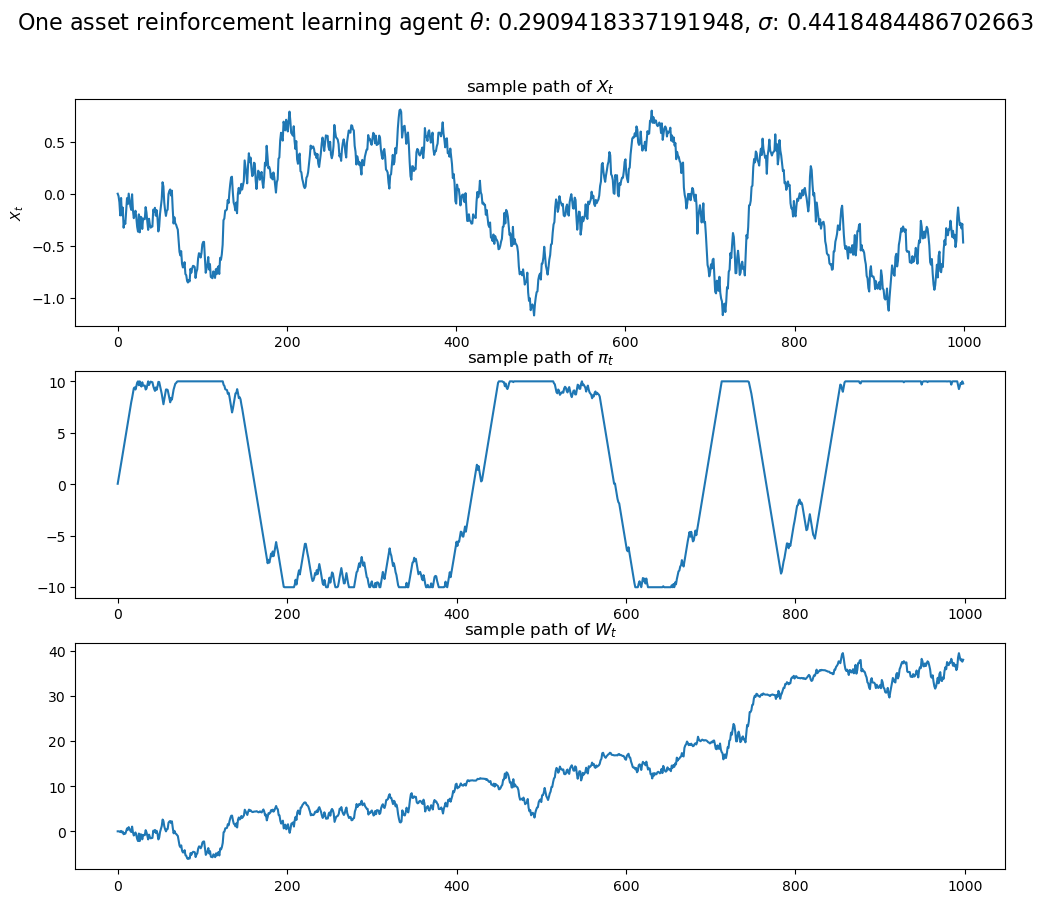

In [354]:
state, _ = env.reset()
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = dict_to_features(state)

    action = policy.select_action(np.array(state))
    #val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = env.step(action)
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
fig.suptitle(fr'One asset reinforcement learning agent $\theta$: {env.process.theta.item()}, $\sigma$: {env.process.sigma.item()}', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(env.W[:-1])
ax[2].set_title(r'sample path of $W_t$')